In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.patches as patches

In [146]:
plt.style.use('../HighFrequencyTrading/MNRAS_stylesheet')

In [147]:
future_NL_GDP = pd.read_csv('./predicted_GDP_future.csv')
future_NL_GDP = future_NL_GDP[['TIME','Value']]
future_NL_GDP['Growth'] = future_NL_GDP.Value.pct_change()+1
future_NL_GDP = future_NL_GDP.set_index('TIME')
future_NL_GDP.loc[2020,'Growth'] = future_NL_GDP.Growth.mean()
future_NL_GDP.Growth = future_NL_GDP.Growth-0.01

In [151]:
future_NL_GDP['r1'] = 1-0.005
future_NL_GDP['r2'] = 1
future_NL_GDP['r3'] = future_NL_GDP.Growth
future_NL_GDP['r4'] = 1+0.01
future_NL_GDP['r5'] = 1+0.03

In [152]:
def debt_progress(df):
    df.columns = ['Growth','Rate']
    df['debt'] = 0
    df.loc[2020,'debt'] = 68.51
    for year in df.index[:-1]:
        g = df.loc[year,'Growth']
        r = df.loc[year,'Rate']
        df.loc[year+1,'debt'] = df.loc[year,'debt'] *(1/g)*r 
    return df

<ipython-input-152-28fa2bf12c39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['debt'] = 0
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

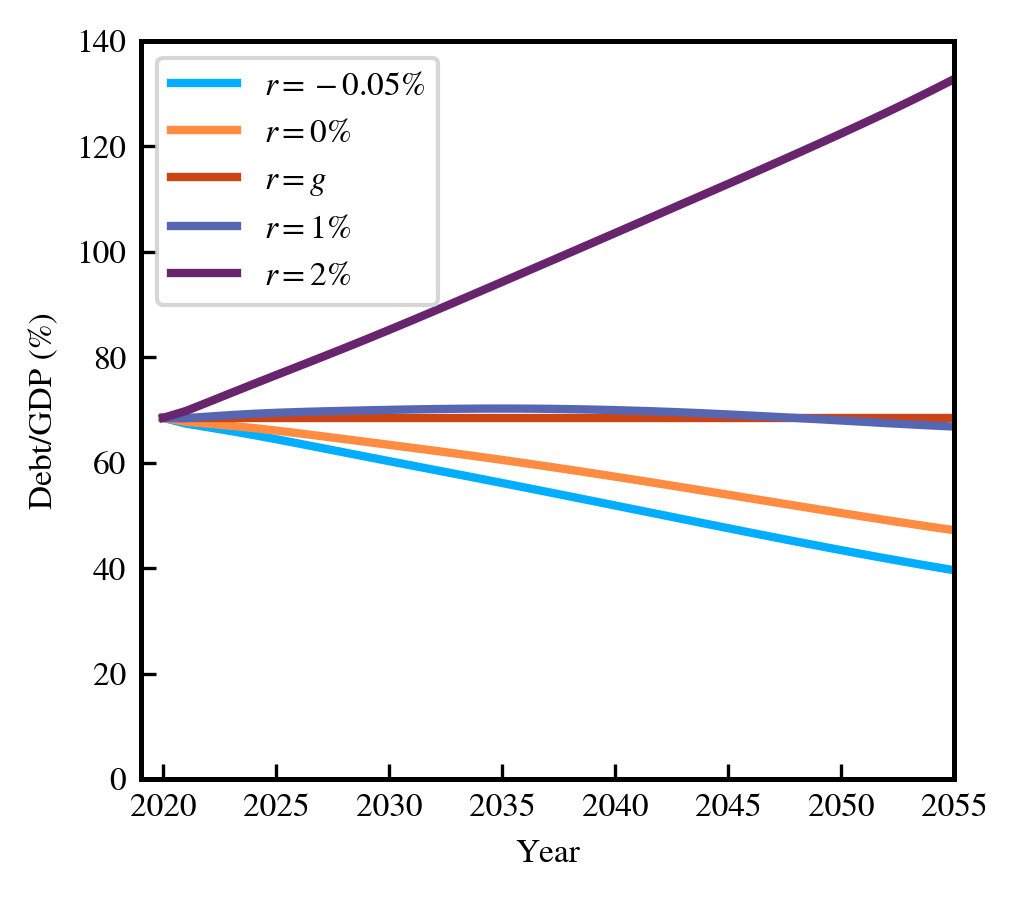

In [156]:
df1 = debt_progress(future_NL_GDP[['Growth','r1']])
df2 = debt_progress(future_NL_GDP[['Growth','r2']])
df3 = debt_progress(future_NL_GDP[['Growth','r3']])
df4 = debt_progress(future_NL_GDP[['Growth','r4']])
df5 = debt_progress(future_NL_GDP[['Growth','r5']])

fig=plt.figure()#figsize=(6,5))
plt.plot(df1.index, df1.debt,label=r'$r=-0.05\%$')
plt.plot(df2.index, df2.debt,label=r'$r=0\%$')
plt.plot(df3.index, df3.debt,label=r'$r=g$')
plt.plot(df4.index, df4.debt,label=r'$r=1\%$')
plt.plot(df5.index, df5.debt,label=r'$r=2\%$')

plt.ylabel('Debt/GDP (%)')
plt.xlabel('Year')
plt.tight_layout()
plt.legend(frameon = 1)
plt.xlim(2019,2055)
plt.ylim(0,140)
plt.savefig('debt_vs_GDP_interestrate.pdf',bbox_inches='tight')

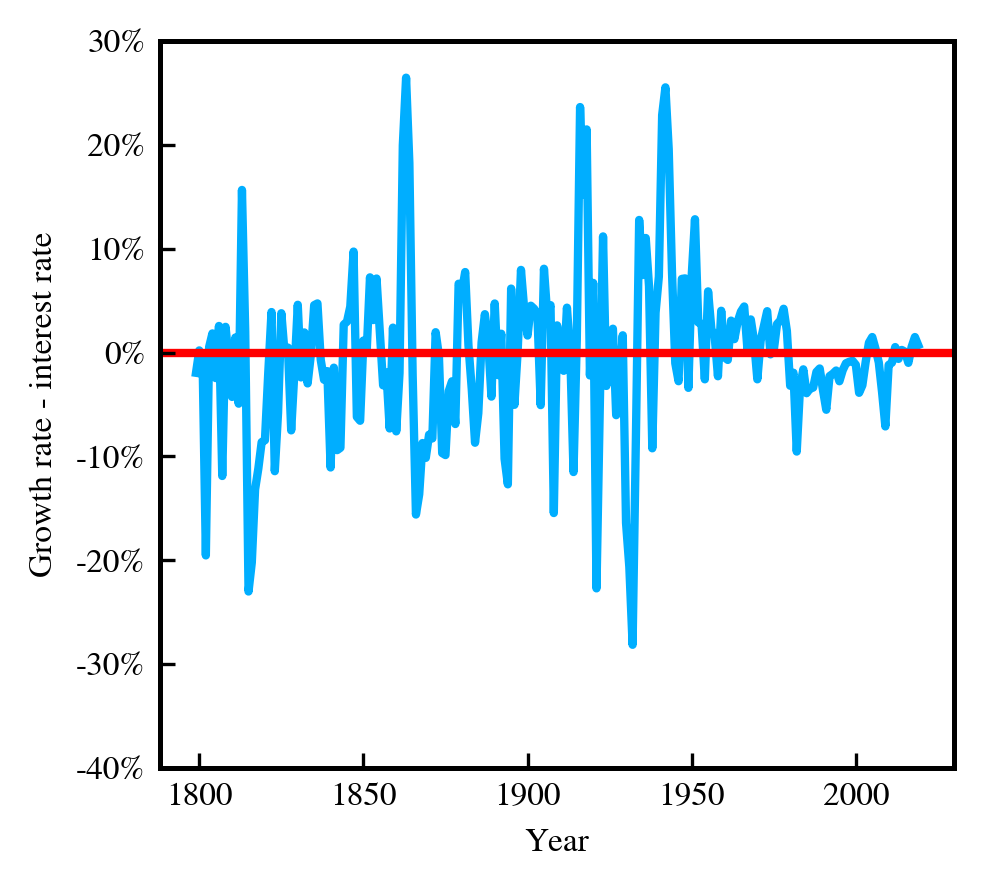

In [158]:
historical_GDP = pd.read_csv('US_historical_gdp.csv').set_index('Year')
historical_interest = pd.read_csv('US_interestrates_historical.csv').set_index('Year')
historical_GDP

historical_interest = historical_interest['US Long-Term Rate: Consistent Series']
historical_GDP = historical_GDP['Nominal GDP (million of Dollars)'].pct_change()*100

plt.figure()#figsize=(6.6,2.4))
plt.plot(historical_GDP - historical_interest)
plt.axhline(0,color='red')

plt.yticks(plt.yticks()[0],labels=[str(int(w))+'%' for w in plt.yticks()[0]])
plt.ylabel('Growth rate - interest rate')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig('historical_growthmininterest.pdf',bbox_inches='tight')

<h3>Monte Carlo Simulations</h3>

In [440]:
future_NL_GDP.loc[2020:2030].Value.pct_change().mean()

0.017579592618392304

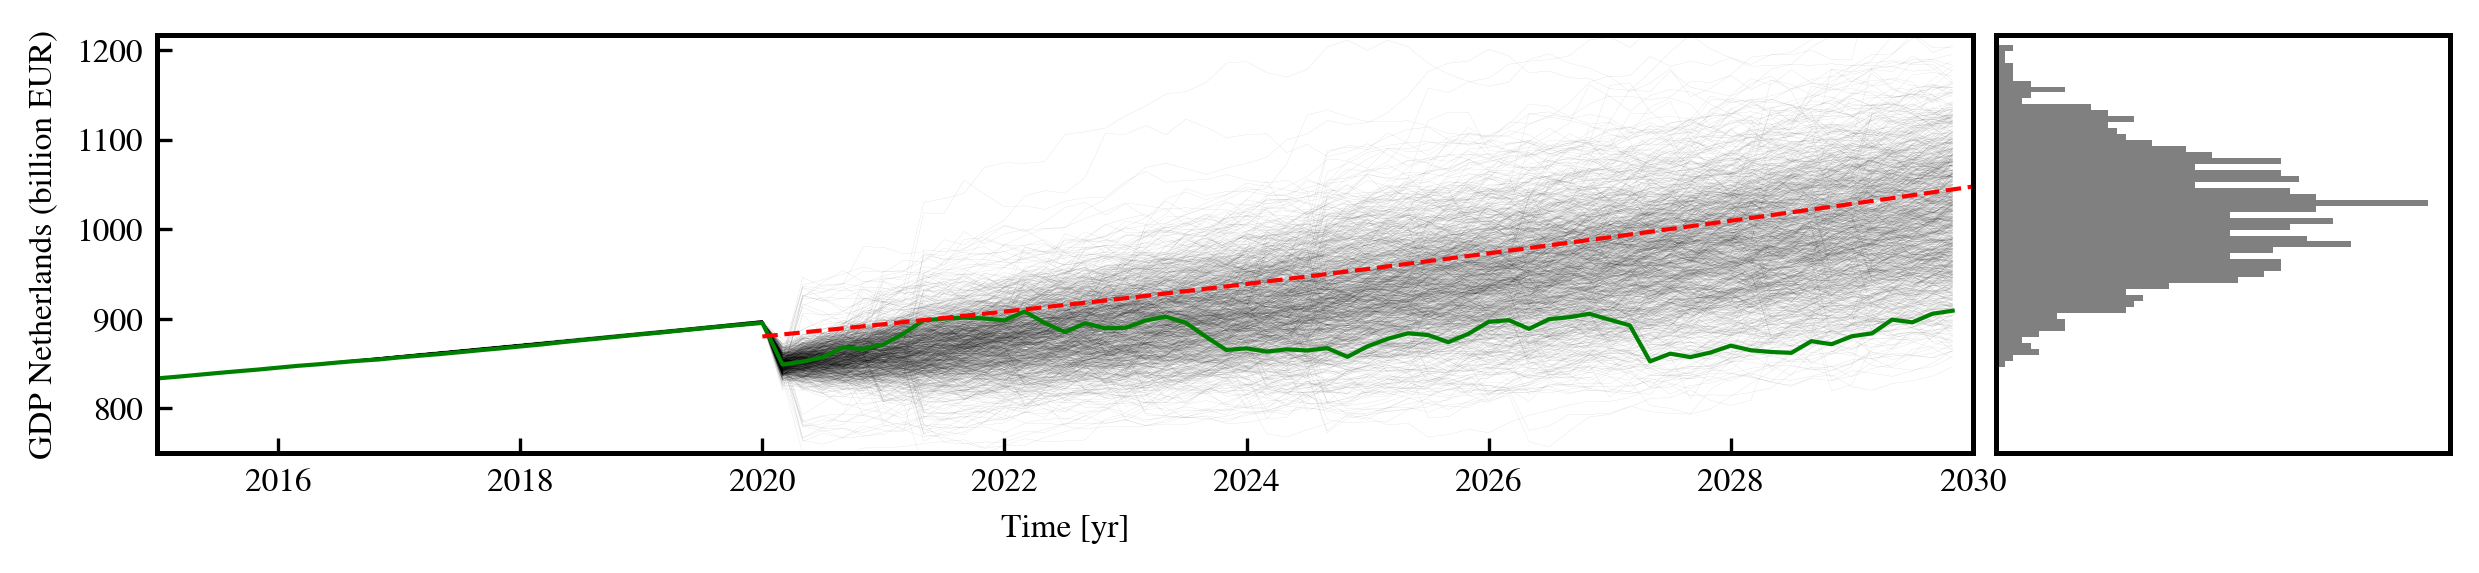

In [490]:
class MC_GDP():
    def __init__(self,sigma = 0.0226, mu = 0.011):
        self.mu =mu
        self.sigma = sigma
        self.x0    = future_NL_GDP.loc[2020,'Value']/(1+mu)**5
        np.random.seed(42)
        self.Npaths=1000
        self.Nsteps=90
        self.T=15
        self.dT = self.T/self.Nsteps
        self.prediction_interp = interp1d(future_NL_GDP.Value.index,future_NL_GDP.Value,kind='quadratic',fill_value='extrapolate')
        self.eta=np.log(2)/(6)
        
    def propagate(self,Sn,year):
        # We generate N(0,1) random variables
        # and multiply by sigma to get N(0,vola^2) variables
        
        phis = np.random.randn(len(Sn))
        shocks_per_year = 0.1
        posshock = np.random.poisson(size=len(Sn),lam=shocks_per_year*self.dT)
        negshock = np.random.poisson(size=len(Sn),lam=shocks_per_year*self.dT)
        shocksize = np.random.randn()*0.03+0.02
        mean = self.prediction_interp(year+2020)
        if year<5:
            sigma = 0.0005
            posshock=0
            negshock=0
        else:
            sigma = self.sigma
        if year==5:
            posshock=0
            negshock=3
        return Sn + Sn * (self.mu*self.dT + sigma*np.sqrt(self.dT)*phis-negshock*shocksize+posshock*shocksize)+0.01*np.exp(-self.eta*self.dT)*(mean-Sn)
            
    def payout(self,prices,T,M):
        # Payout is price - strike IF larger than zero. Thus take max(0,S-K)
        payoff = np.max(np.vstack(((prices - self.K),
                                    np.zeros(len(prices)))),axis=0)
        # Discount by rf rate
        return np.exp(-1*self.mu * T)* np.mean(payoff)
    
    def simulate(self,M,N,T):
        dT = T/N
        # Start all at S0
        prices = np.ones(M) * self.S0
        # Iterate through N steps by the Euler equation
        for i in range(N):
            prices = self.propagate(prices,dT)
        # Get payout from these prices
        payout = self.payout(prices,T,M)
        return payout
    
    def simulate_many(self):
        """Simulate Npaths for Nsteps"""
        xt = np.zeros((self.Npaths, self.Nsteps))
        # Same as before but now a whole matrix with N paths
        xt[:,0] = self.x0
        for i in range(self.Nsteps-1):
            xt[:,i+1] = self.propagate(xt[:,i],i*self.dT)
        prices = xt
        return prices
    
    def plot_many(self):
        """Make a plot of the overall distribution and also plot the resulting PDF of final 
           GDPs."""
        prices = self.simulate_many()
        prices = prices/1e3
        timearr = np.arange(2015,2030,self.dT)
        fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]},figsize=(8,1.7))
        for i in range(self.Npaths-1):
            a0.plot(timearr,prices[i,:],color='black',lw=0.01)
        a0.plot(timearr,prices[i,:],color='green',lw=1.0)
        
        limits = 0.9*np.min(prices[:,0]),1.1*np.percentile(prices[:,-1],q=90)
        
        a0.set_xlabel('Time [yr]')
        a0.set_ylabel('GDP Netherlands (billion EUR)')
        a0.set_xticks(a0.get_xticks()[:-1])
        a0.set_xlim(2015,2030)
        a0.set_ylim(limits)
        a0.plot(future_NL_GDP.index,future_NL_GDP.Value.values/1e3,color='red',ls='--',lw=1)
        
        a1.hist(prices[:,-1],bins=70, orientation="horizontal", color='gray')
        a1.set_xticks([])
        a1.set_yticks([])
        a1.set_ylim(limits)
        a0.set_rasterized(True)
        fig.tight_layout(pad=-0.3)
        plt.savefig('manyMCtracks_PDF.png', dpi=400,bbox_inches='tight')
        
        plt.show()
        return prices
# Exercise a
MC = MC_GDP()
future_GDPs = MC.plot_many()

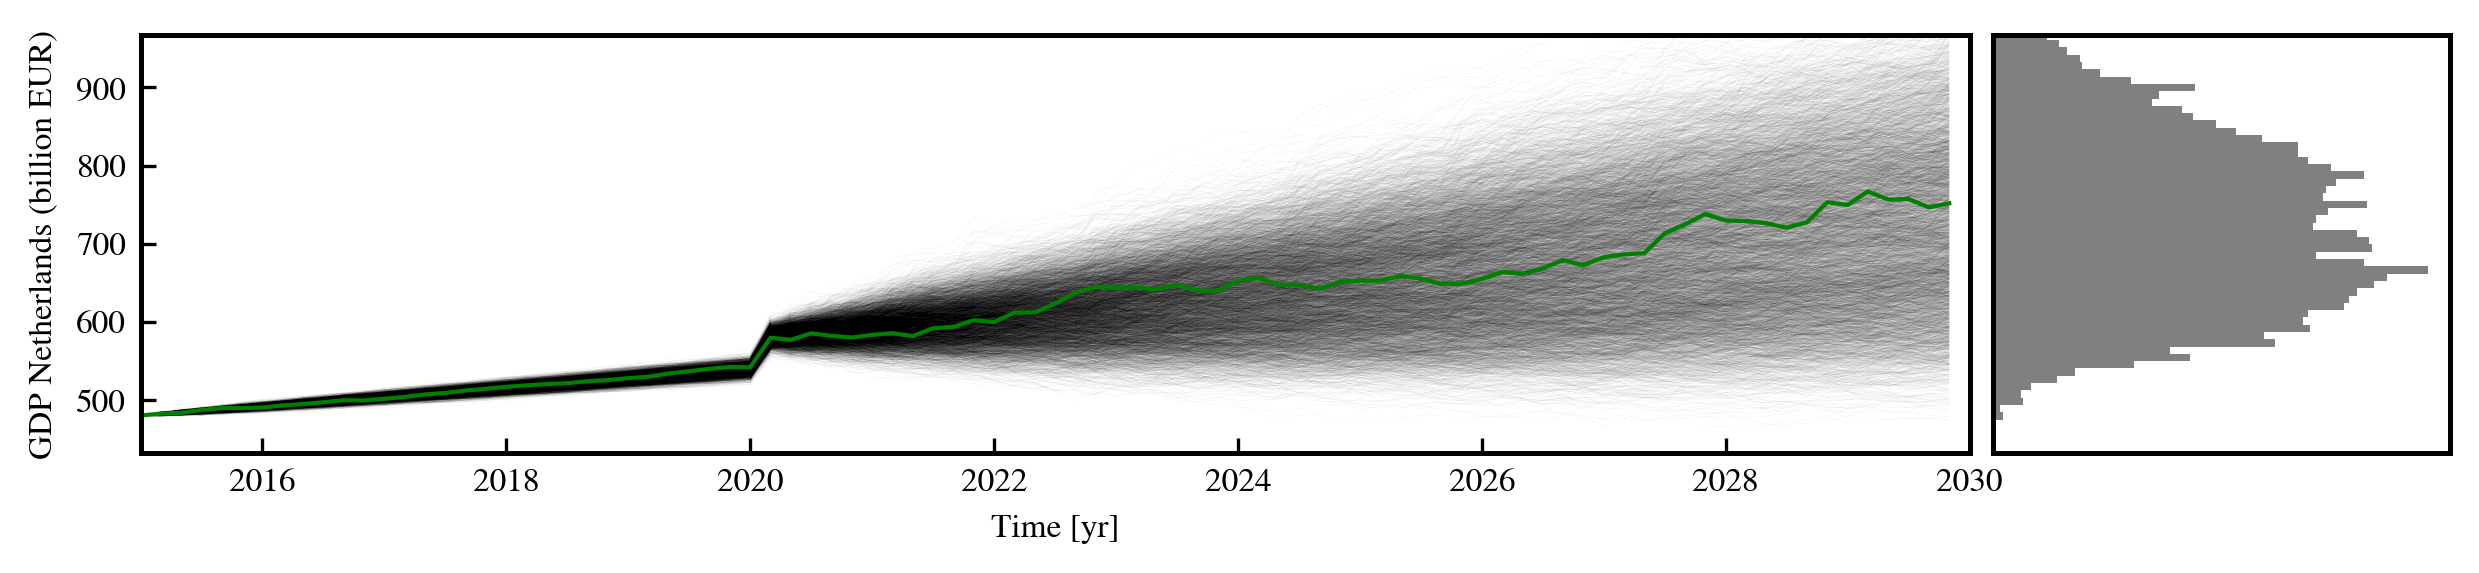

In [489]:
class MC_debt():
    def __init__(self,sigma = 0.0226, mu = 0.023480):
        self.mu =mu
        self.sigma = sigma
        self.x0    = 480000
        np.random.seed(42)
        self.Npaths=5000
        self.Nsteps=90
        self.T=15
        self.dT = self.T/self.Nsteps
        
    def propagate(self,Sn,year):
        # We generate N(0,1) random variables
        # and multiply by sigma to get N(0,vola^2) variables
        try:
            self.economy = np.sin(year/4 - self.phase)+0.5
        except: 
            # All economy at 0
            self.phase = np.random.randn(len(Sn))*np.pi
            self.economy = np.sin(year/4 - self.phase)+0.5
            
        phis = np.random.randn(len(Sn))
        shocks_per_year = 0.5
        
        if year<5:
            sigma = 0.005
            self.economy = 1
            posshock=0
            shocksize=0
        else:
            sigma = self.sigma
        if year==5:
            posshock = 1
            shocksize = np.random.randn()*0.01+0.06
        if year>5:
            posshock = np.random.poisson(size=len(Sn),lam=shocks_per_year*self.dT)
            shocksize = np.random.randn()*0.01+0.02
            
        return Sn + Sn * (self.economy*self.mu*self.dT + sigma*np.sqrt(self.dT)*phis+posshock*shocksize)+np.clip(15000*(self.x0/Sn-1),0,np.inf)
     
    def simulate_many(self):
        """Simulate Npaths for Nsteps"""
        xt = np.zeros((self.Npaths, self.Nsteps))
        # Same as before but now a whole matrix with N paths
        xt[:,0] = self.x0
        for i in range(self.Nsteps-1):
            xt[:,i+1] = self.propagate(xt[:,i],i*self.dT)
        prices = xt
        return prices
    
    def plot_many(self):
        """Make a plot of the overall distribution and also plot the resulting PDF of final 
           GDPs."""
        prices = self.simulate_many()
        prices = prices/1e3
        timearr = np.arange(2015,2030,self.dT)
        fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]},figsize=(8,1.7))
        for i in range(self.Npaths-1):
            a0.plot(timearr,prices[i,:],color='black',lw=0.005)
        a0.plot(timearr,prices[i,:],color='green',lw=1.0)
        
        limits = 0.9*np.min(prices[:,0]),1.1*np.percentile(prices[:,-1],q=90)
        
        a0.set_xlabel('Time [yr]')
        a0.set_ylabel('GDP Netherlands (billion EUR)')
        a0.set_xticks(a0.get_xticks()[:-1])
        a0.set_xlim(2015,2030)
        a0.set_ylim(limits)
        
        
        a1.hist(prices[:,-1],bins=70, orientation="horizontal", color='gray')
        a1.set_xticks([])
        a1.set_yticks([])
        a1.set_ylim(limits)
        a0.set_rasterized(True)
        fig.tight_layout(pad=-0.3)
        #plt.savefig('manyMCtracks_PDF.png', dpi=400,bbox_inches='tight')
        
        plt.show()
        return prices
# Exercise a
MC = MC_debt()
future_debt = MC.plot_many()

Text(0, 0.5, 'Debt/GDP (%)')

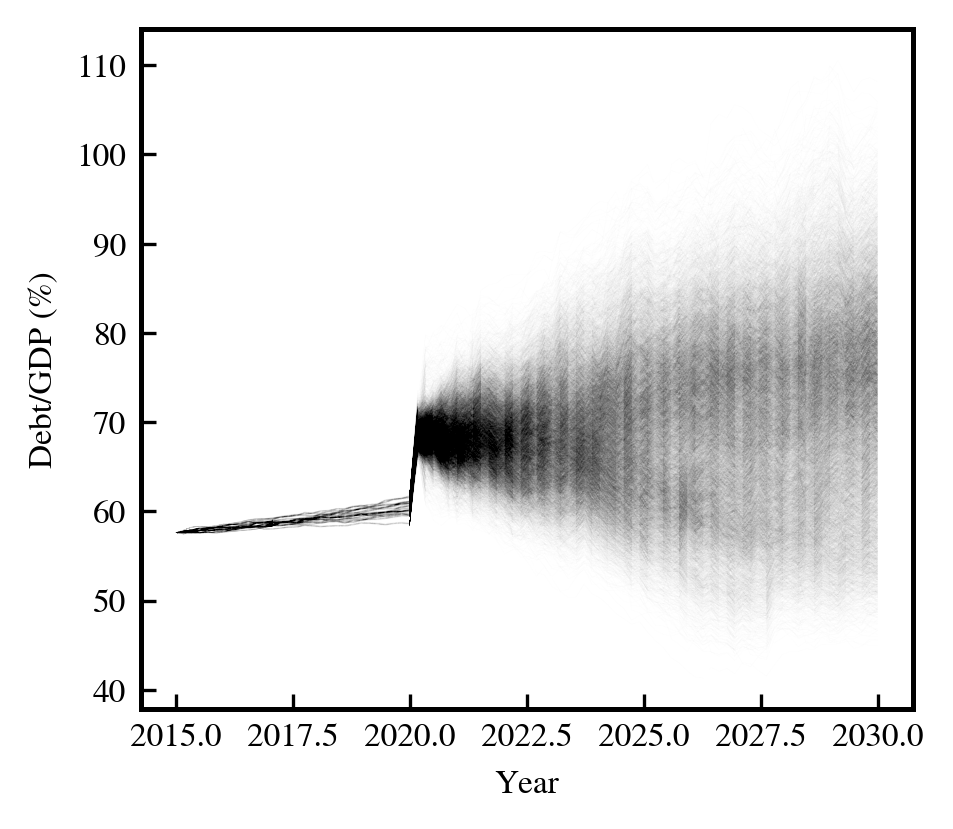

In [500]:
for i in future_debt[180:200,:]:
    relative_debt = i/future_GDPs[500:1000,:]
    for i in relative_debt:
        plt.plot(np.linspace(2015,2020,30),i[:30]*100,color='black',lw=0.0001)
        plt.plot(np.linspace(2020,2030,60),i[30:]*100,color='black',lw=0.001)
plt.xlabel('Year')
plt.ylabel('Debt/GDP (%)')

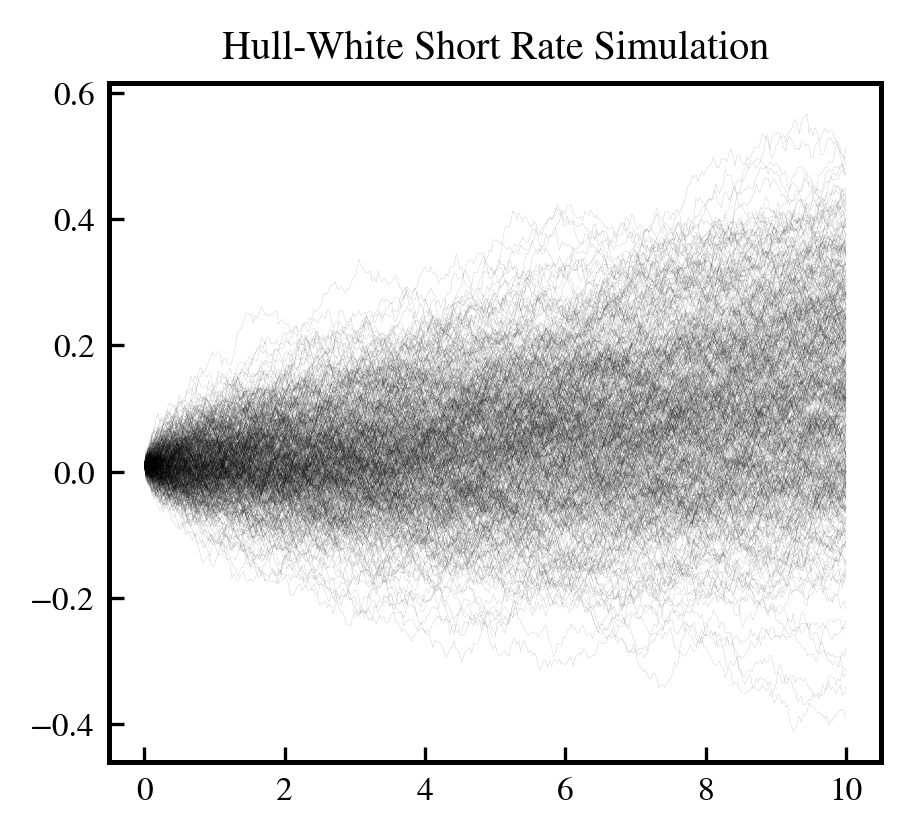

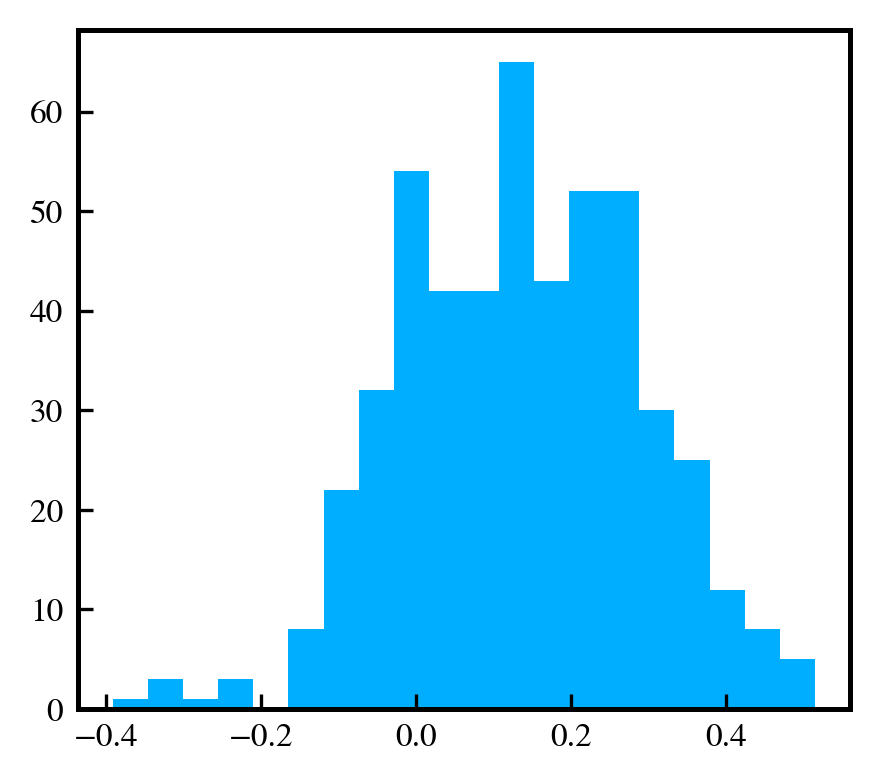

In [268]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np



sigma = 0.05
a = 0.1
timestep = 360
length = 10 # in years
forward_rate = 0.01
day_count = ql.Thirty360()
todays_date = ql.Date(15, 1, 2020)

ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

num_paths = 500
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.02, color='black')
plt.title("Hull-White Short Rate Simulation")
plt.show()

plt.hist(paths[:,-1],bins=20)
plt.show()

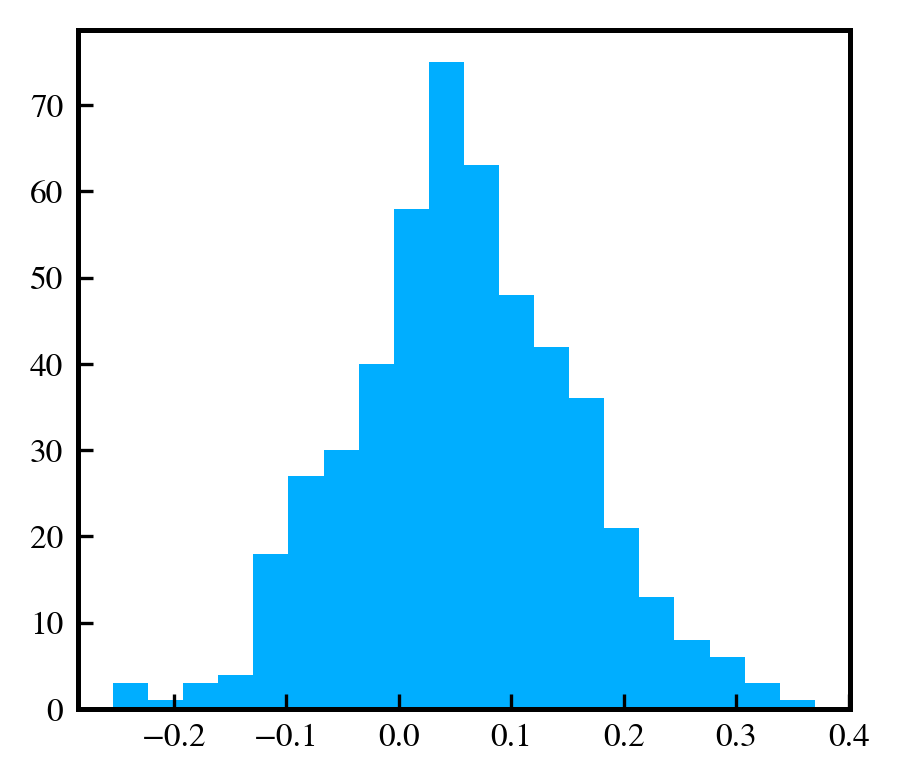

In [29]:
government_debt = pd.read_csv('./datafiles/government_debt.csv').set_index('Country')
government_debt = government_debt.replace({'no data':np.nan})
government_debt = government_debt.astype(float)
gross_debt_outlook.columns = gross_debt_outlook.columns.astype(float)
public_debt = pd.read_csv('./datafiles/public_debt.csv').set_index('Country')
public_debt = public_debt.replace({'no data':np.nan})
public_debt = public_debt.astype(float)
public_debt.columns = public_debt.columns.astype(float)
real_GDP_growth = pd.read_csv('./datafiles/real_GDP_growth.csv').set_index('Country')
real_GDP_growth = real_GDP_growth.replace({'no data':np.nan})
real_GDP_growth = real_GDP_growth.astype(float)
real_GDP_growth.columns = real_GDP_growth.columns.astype(float)
inflation_rate = pd.read_csv('./datafiles/inflation_rate.csv').set_index('Country')
inflation_rate = inflation_rate.replace({'no data':np.nan})
inflation_rate = inflation_rate.astype(float)
inflation_rate.columns = inflation_rate.columns.astype(float)

gross_debt_outlook = pd.read_csv('./datafiles/gros_debt_outlook.csv').set_index('Country')
gross_debt_outlook = gross_debt_outlook.replace({'no data':np.nan})
gross_debt_outlook = gross_debt_outlook.astype(float)
gross_debt_outlook.columns = gross_debt_outlook.columns.astype(float)

net_debt_outlook = pd.read_csv('./datafiles/net_debt_outlook.csv').set_index('Country')
net_debt_outlook = net_debt_outlook.replace({'no data':np.nan})
net_debt_outlook = net_debt_outlook.astype(float)
net_debt_outlook.columns = net_debt_outlook.columns.astype(float)

In [7]:
country_type = pd.read_csv('./datafiles/countries_classification.csv')
country_classification = pd.DataFrame({'Country':[],'Type':[]})
i=0
types = {'Advanced Economies':'Advanced Economies','Emerging\nMarket and Middle-Income Economies\n':'Emerging markets','Low-Income Developing\nCountries\n':'Low income'}
for col in ['Advanced Economies','Emerging\nMarket and Middle-Income Economies\n','Low-Income Developing\nCountries\n']:
    for item in country_type[col].dropna().values:
        country_classification = country_classification.append({'Country':item,'Type':types[col]},ignore_index=True)

In [8]:
country_classification = country_classification.set_index('Type')

In [9]:
inflation = inflation_rate.iloc[:,35:40].agg(['median','std'],axis=1)
gov_debt  = government_debt.iloc[:,64:70].agg(['median','std'],axis=1)
GDP_growth = real_GDP_growth.iloc[:,35:40].agg(['median','std'],axis=1)

In [10]:
merged = pd.merge(inflation,gov_debt,left_index=True,right_index=True)
merged = pd.merge(merged,GDP_growth,left_index=True,right_index=True)
merged.columns = ['median_infl','std_infl','median_govdebt','std_govdebt','median_growth','std_growth']


Text(0, 0.5, 'Average GDP Growth (2015-2019)')

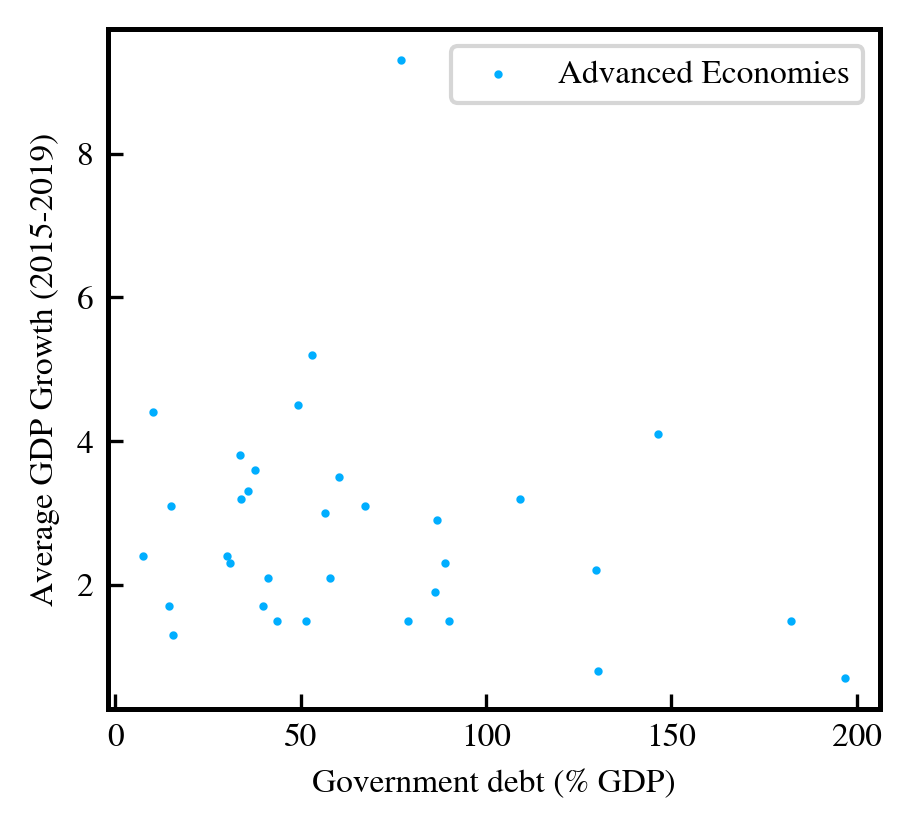

In [11]:
for type_ in country_classification.index.unique()[:1]:
    countries = country_classification.loc[type_].values.flatten()
    df = merged.reindex(countries)
    #, xerr=df.std_govdebt,yerr=df.std_growth,ls='none'
    plt.scatter(x=df.median_govdebt,y=df.median_growth,s=1,label=type_)
plt.legend(frameon=1)
plt.xlabel('Government debt (% GDP)')
plt.ylabel('Average GDP Growth (2015-2019)')

Text(0, 0.5, 'Average inflation (2015-2019)')

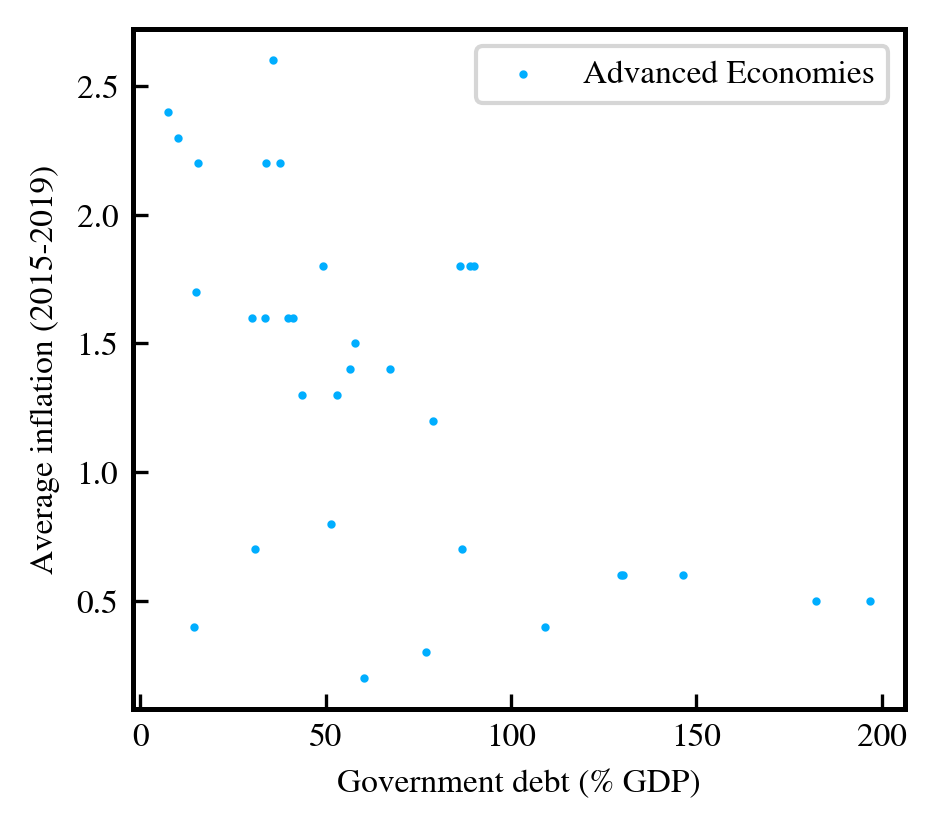

In [12]:
for type_ in country_classification.index.unique()[:1]:
    countries = country_classification.loc[type_].values.flatten()
    df = merged.reindex(countries)
    df = df[df.std_infl<100]
    #, xerr=df.std_govdebt,yerr=df.std_infl,ls='none',lw=1
    plt.scatter(x=df.median_govdebt,y=df.median_infl,label=type_,s=1)
plt.legend(frameon=1)
plt.xlabel('Government debt (% GDP)')
plt.ylabel('Average inflation (2015-2019)')

In [ ]:
fig,ax = plt.subplots()

In [80]:
gross_debt_outlook.index[-15:]

Index(['Advanced G-20', 'Advanced economies', 'Emerging G-20',
       'Emerging Market and Middle-Income Economies',
       'Emerging and Middle-Income Asia', 'Emerging and Middle-Income Europe',
       'Emerging and Middle-Income Latin America',
       'Emerging and Middle-Income Middle East and North Africa and Pakistan',
       'Euro area', 'Low-Income Developing Asia',
       'Low-Income Developing Countries',
       'Low-Income Developing Latin America',
       'Low-Income Developing Oil Producers', 'Low-Income Developing Others',
       'Low-Income Developing Sub-Saharan Africa'],
      dtype='object', name='Country')

In [91]:
advanced_economies = pd.read_csv('./datafiles/imf_debts_advanced.txt',delimiter=', ',skiprows=1,header=None)
emerging_economies = pd.read_csv('./datafiles/imf_debts_emerging.txt',delimiter=', ',skiprows=1,header=None)

<ipython-input-91-801155026211>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  advanced_economies = pd.read_csv('./datafiles/imf_debts_advanced.txt',delimiter=', ',skiprows=1,header=None)
<ipython-input-91-801155026211>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  emerging_economies = pd.read_csv('./datafiles/imf_debts_emerging.txt',delimiter=', ',skiprows=1,header=None)


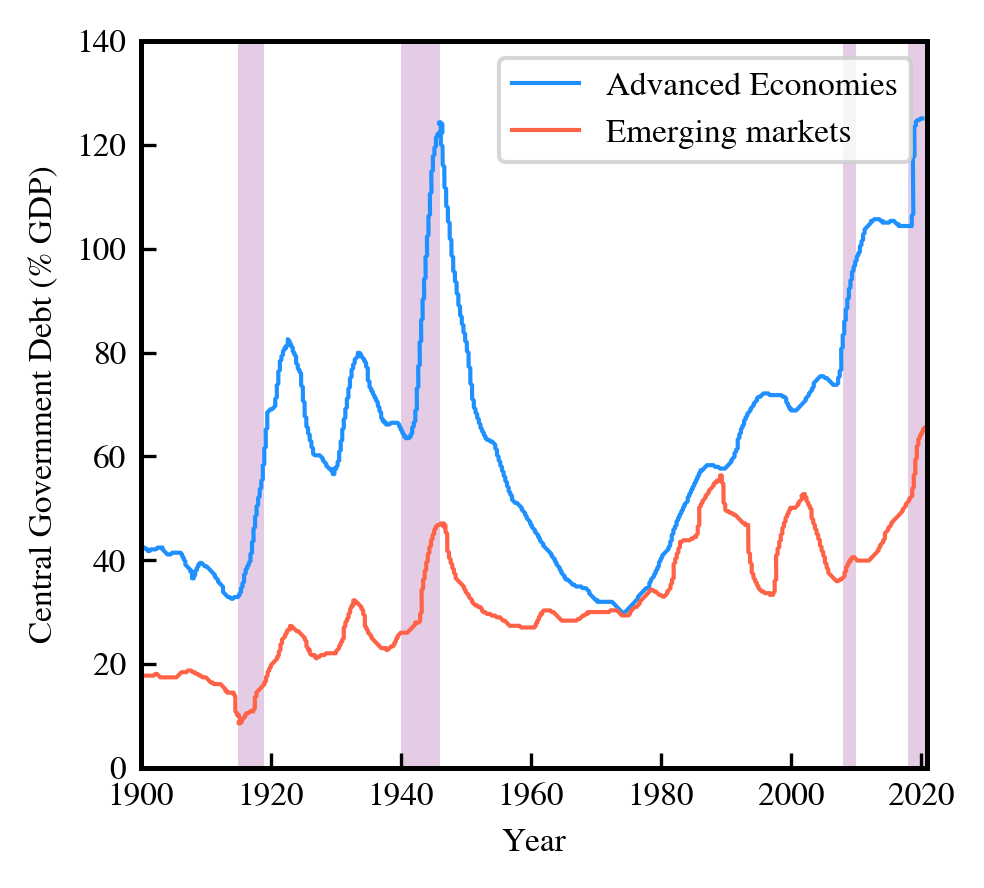

In [144]:
fig,ax = plt.subplots()
ax.plot(advanced_economies.iloc[:,0],advanced_economies.iloc[:,1],lw=1,color='dodgerblue',label='Advanced Economies')
ax.plot(emerging_economies.iloc[:,0],emerging_economies.iloc[:,1],lw=1,color='tomato',label='Emerging markets')
ax.set_xlim(1900,2021)
ax.set_xlabel('Year')
ax.set_ylabel('Central Government Debt (% GDP)')
rect1 = patches.Rectangle((2008,-10),2,200,linewidth=1,edgecolor='none',facecolor='purple',alpha=0.2)
rect2 = patches.Rectangle((2018,-10),3,200,linewidth=1,edgecolor='none',facecolor='purple',alpha=0.2)
rect3 = patches.Rectangle((1940,-10),6,200,linewidth=1,edgecolor='none',facecolor='purple',alpha=0.2)
rect4 = patches.Rectangle((1915,-10),4,200,linewidth=1,edgecolor='none',facecolor='purple',alpha=0.2)
ax.set_ylim(0,140)
# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
plt.legend(frameon=1)
plt.tight_layout()
plt.savefig('IMF_debt.pdf')

<h3>DSG model</h3>

In [20]:
debt

1950     2.212389
1951     1.875000
1952     2.905812
1953     2.569316
1954     2.773438
          ...    
2014    34.870700
2015    38.487751
2016    43.550026
2017    43.309947
2018    41.367616
Length: 69, dtype: float64